In [ ]:
# @YØUNG. 我们train---validation---test就用{2020-2-3到2021-12-31}---{2022-1-3到2022-2-28}---{2022-3-1到2022-5-31}？

In [125]:
# Hang Seng Composite Index-Energy Sector Historical Data-before

# view series
library(xts)
library(fUnitRoots)
library(forecast)
# setwd("C:/Users/Young/OneDrive - HKUST Connect/MAFS 5130/5130 Assignment/5130 Project")
data_b <- read.csv("../data/恒生综合指数-金融业历史数据-2.csv", header = TRUE, col.names = c("date", "close", "open", "high", "low", "volume", "variation"))
data_b$date <- as.Date(data_b$date)
data_b$close <- as.numeric(gsub(",", "", data_b$close))
sorted_index <- order(data_b$date)
data_b <- data_b[sorted_index, ]

data_b_train = with(data_b, data_b[(date >= "2020-02-03") & (date <= "2021-12-31"), ])
data_b_val = with(data_b, data_b[(date >= "2022-01-03") & (date <= "2022-02-28"), ])
data_b_test = with(data_b, data_b[(date >= "2022-03-01"), ])

In [126]:
log_return = diff(log(data_b_train$close))

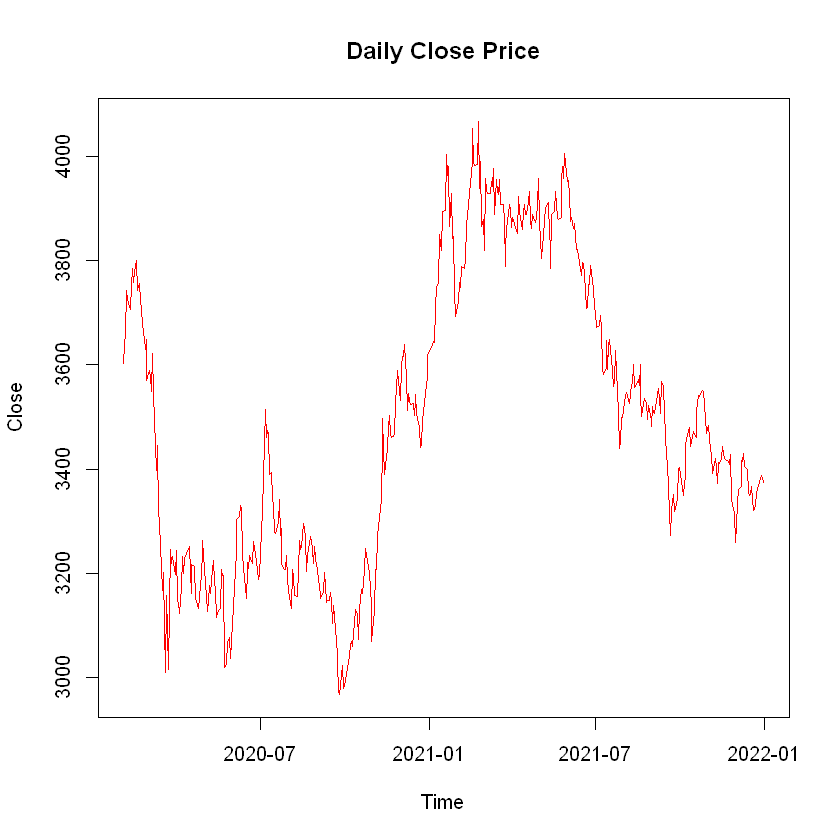

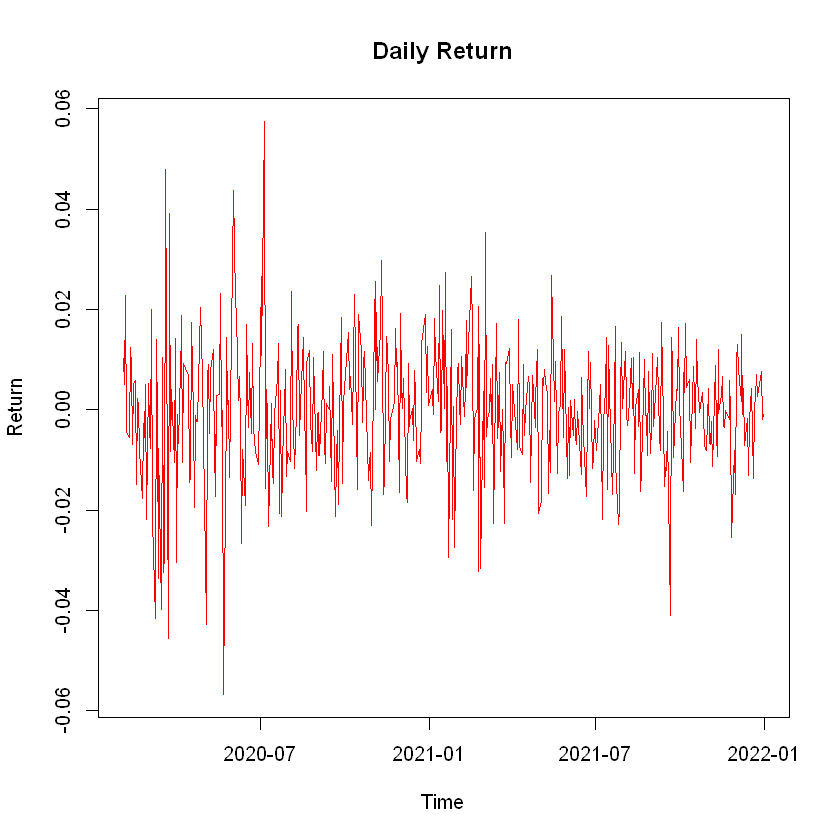

In [127]:
#### Visualization
date_strings <- data_b_train[[1]]
dates <- as.Date(date_strings, format="%Y/%m/%d")
plot(dates, data_b_train$close , xlab="Time", ylab="Close", main="Daily Close Price", type="l", col="red")
start_date = dates[2:length(dates)]
plot(start_date, log_return , xlab="Time", ylab="Return", main="Daily Return", type="l", col="red")

In [128]:
# check stationary
unitrootTest(log_return, lags=12, type=c("c"),)
#### 2.164e-08 
####Rejecting the Null Hypothesis: Given the very small p-value associated with the test statistic (3.763e-07), you can reject the null hypothesis of a unit root at any conventional significance level. This implies that the time series data log_return is stationary.
####d=0


Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 12
  STATISTIC:
    DF: -6.4172
  P VALUE:
    t: 2.164e-08 
    n: 0.3135 

Description:
 Sat May  4 19:13:31 2024 by user: 82438

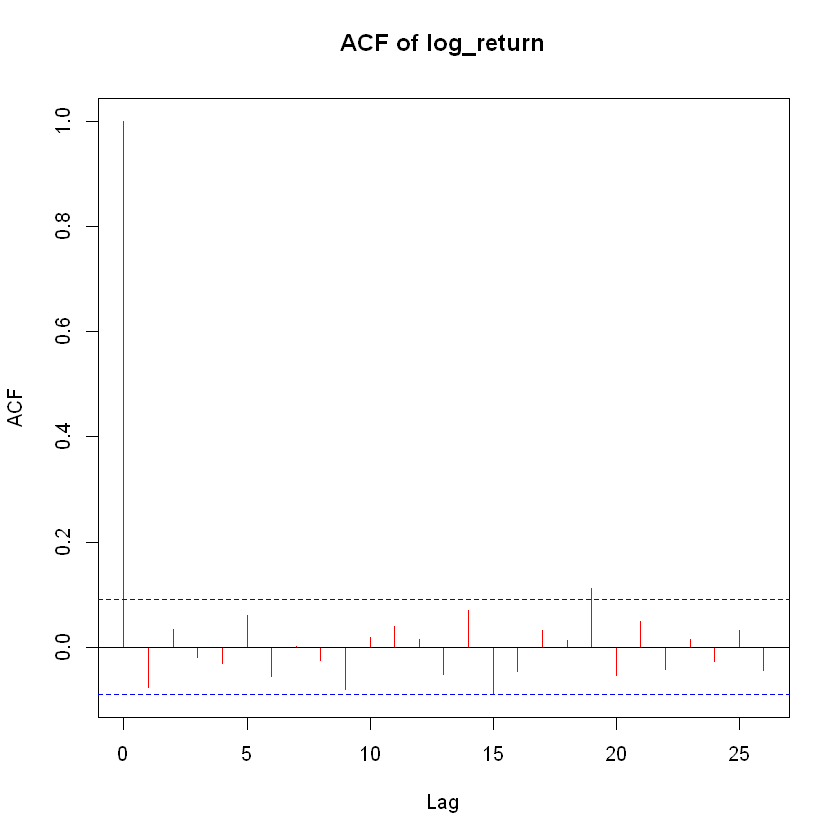


	Box-Ljung test

data:  log_return
X-squared = 11.622, df = 12, p-value = 0.4765


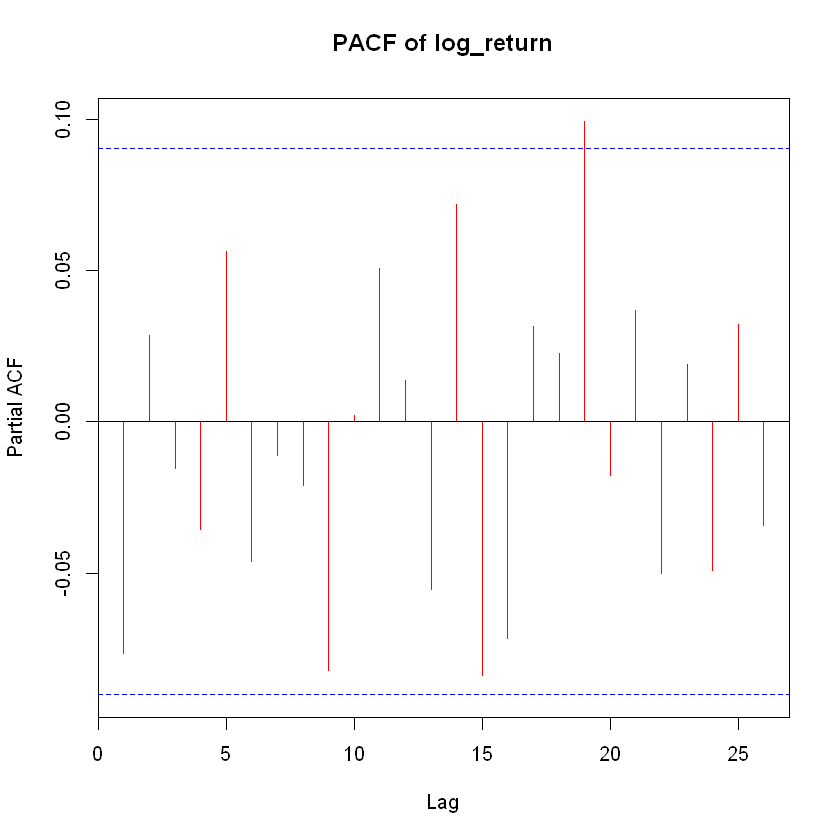

In [129]:
# check serial corr
acf(log_return, main="ACF of log_return", col="red")
pacf(log_return, main="PACF of log_return", col="red")
Box.test(log_return,lag = 12,type = "Ljung")
####The high p-value in the Box-Ljung test (0.4765) suggests that the series does not exhibit significant autocorrelation at the tested lags. This implies that the daily returns are essentially random, which is a desirable property in financial time series analysis, indicating that the market is efficient and past returns do not predict future returns.

In [130]:
# check ARCH effect
return_a =log_return-mean(log_return)
Box.test(return_a^2,lag=12,type="Ljung")
#### 6.327e-13
#### The significant Box-Ljung test statistic and the extremely low p-value strongly suggest that there is autocorrelation present in the squared returns. This is typically indicative of an ARCH (Autoregressive Conditional Heteroskedasticity) effect, where the volatility (variance of returns) changes over time in a predictable pattern, often responding to shifts in the market or external factors.


	Box-Ljung test

data:  return_a^2
X-squared = 84.255, df = 12, p-value = 6.327e-13


In [131]:
# check with constanst term or not
n <- length(log_return)
t <- mean(log_return)/(sd(log_return) / sqrt(n))
upper_qt <- qt(0.975, n-1, lower.tail = TRUE, log.p = FALSE)
lower_qt <- qt(0.025, n-1, lower.tail = TRUE, log.p = FALSE)
t # -0.2233512
upper_qt # 1.965013
lower_qt # -1.965013
#### There is no statistically significant evidence that the mean return differs from zero. This suggests that including a constant term in a model for log_return might not be necessary if the aim is to model the mean of the returns.

[1] -0.2233512

[1] 1.965013

[1] -1.965013

In [132]:
# checking Distribution
x<-log_return+0.00000000000000000000000001*rnorm(length(log_return),0,1)
ks.test(x,"pnorm",mean=mean(x),sd=sd(x))
# Asymptotic one-sample Kolmogorov-Smirnov test
# data:  x
# D = 0.053762, p-value = 0.1306
# alternative hypothesis: two-sided
library(nortest)
ad.test(x)
# Anderson-Darling normality test
# data:  x
# A = 2.0193, p-value = 3.805e-05


	Asymptotic one-sample Kolmogorov-Smirnov test

data:  x
D = 0.053762, p-value = 0.1306
alternative hypothesis: two-sided



	Anderson-Darling test of goodness-of-fit
	Null hypothesis: uniform distribution
	Parameters assumed to be fixed

data:  x
An = Inf, p-value = 1.271e-06


In [136]:
library("Rfast")
library("ramify")
library("LambertW")
x<-as.matrix(x)
df=seq(2,8,0.001)       #set the range of degree of freedom (e.g. df=[2,2.001,...,8])
n=length(df)            
loglik=rep(0,n)         #Used to store the value of loglikelihood function for different level of df
for(i in 1:n){
  fitres=mvt.mle(x,v=df[i])
  loglik[i]=fitres$loglik
}                   #For each df, calculate the MLE and loglikelihood function
loglik<-as.matrix(loglik)
dfmax=df[argmax(loglik,rows=FALSE)] #Find the maximizier(optimal df)
fitMLE=mvt.mle(x,v=dfmax) #Estimate the MLE of the parameters
m<-fitMLE$location            #m=mu (location)
s<-sqrt(fitMLE$scatter[1,1])  #s=lambda (scale parameter)
print(m)# 0.0001033967
print(s)# 0.01061283
print(dfmax)# 5.209

[1] 0.0001033967
[1] 0.01061283
[1] 5.209


In [137]:
ks_test_t(x,c(location=m,scale=s,df=dfmax)) #do the testing using ks.test
# One-sample Kolmogorov-Smirnov test student-t with df=5.21, location=0, scale=0.01
# data:  x
# D = 0.024866, p-value = 0.9323
# alternative hypothesis: two-sided


	One-sample Kolmogorov-Smirnov test student-t with df=5.21, location=0,
	scale=0.01

data:  x
D = 0.024866, p-value = 0.9323
alternative hypothesis: two-sided


In [138]:
library("goftest")
ad.test((x-m)/s,null="pt",df=dfmax)
# Anderson-Darling test of goodness-of-fit
# Null hypothesis: Student's t distribution
# 	with parameter df = 5.209
# 	Parameters assumed to be fixed
# data:  (x - m)/s
# An = 0.26468, p-value = 0.9621


	Anderson-Darling test of goodness-of-fit
	Null hypothesis: Student's t distribution
	with parameter df = 5.209
	Parameters assumed to be fixed

data:  (x - m)/s
An = 0.26468, p-value = 0.9621


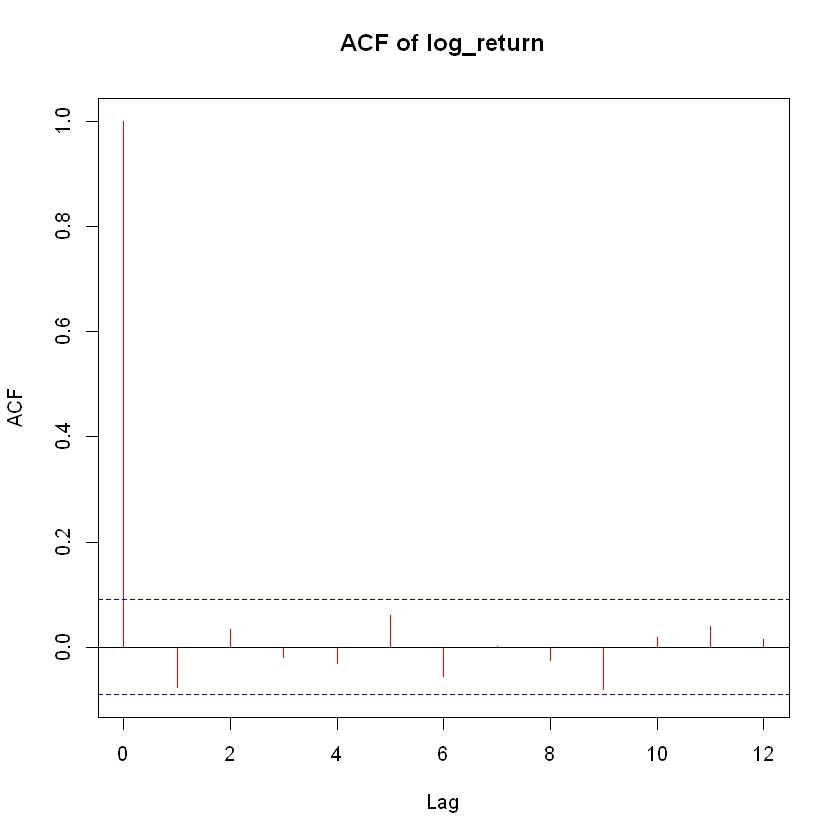

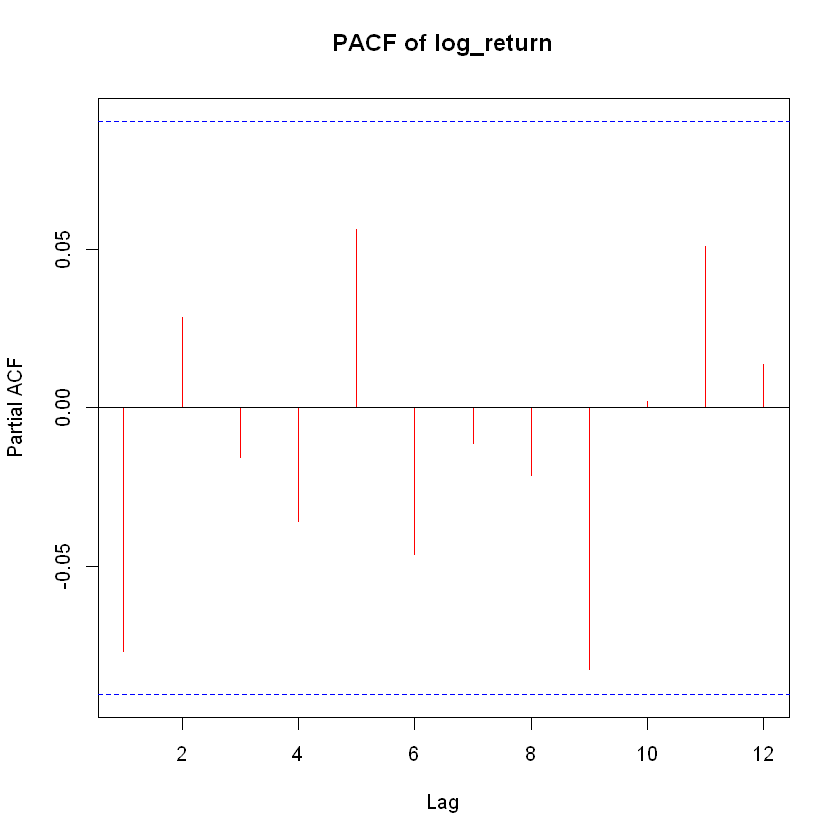

In [139]:
# t-dist

# choose p&q and P&Q
#### no P&Q
acf(log_return,lag=12, main="ACF of log_return", col="red")
pacf(log_return,lag=12, main="PACF of log_return", col="red")

Call:
arima(x = log_return, order = c(0, 0, 0))

Coefficients:
    intercept 
-0.0001379048 

sigma^2 estimated as 0.0001795573:  log likelihood = 1365.765,  aic = -2727.53

Call:
arima(x = log_return, order = c(0, 0, 1))

Coefficients:
          ma1     intercept 
-0.0724970429 -0.0001389422 

sigma^2 estimated as 0.0001785577:  log likelihood = 1367.08,  aic = -2728.159

Call:
arima(x = log_return, order = c(1, 0, 0))

Coefficients:
          ar1     intercept 
-0.0767026828 -0.0001393371 

sigma^2 estimated as 0.0001784978:  log likelihood = 1367.159,  aic = -2728.317

Call:
arima(x = log_return, order = c(1, 0, 1))

Coefficients:
          ar1           ma1     intercept 
-0.3516019271  0.2750343783 -0.0001397176 

sigma^2 estimated as 0.0001783665:  log likelihood = 1367.332,  aic = -2726.663

Model 1 :
data:  est_a_list[[1]]$residuals
X-squared = 11.6215, df = 12, p-value = 0.4765

Model 2 :
data:  est_a_list[[2]]$residuals
X-squared = 8.4898, df = 12, p-value = 0.7458

Model 3 :


	Box-Ljung test

data:  res_sGARCH11
X-squared = 7.7718, df = 12, p-value = 0.8027



	Box-Ljung test

data:  res_sGARCH11^2
X-squared = 9.4483, df = 12, p-value = 0.6642


[1] 0.8027032
[1] 0.6642384
[1] -5.886253
[1] -5.859831

Title:
 GARCH Modelling 

Call:
 garchFit(formula = w2 ~ arma(0, 0) + garch(2, 1), data = log_return, 
    cond.dist = c("std"), include.mean = FALSE, trace = F) 

Mean and Variance Equation:
 data ~ arma(0, 0) + garch(2, 1)
<environment: 0x000001a693a33a28>
 [data = log_return]

Conditional Distribution:
 std 

Coefficient(s):
     omega      alpha1      alpha2       beta1       shape  
1.6562e-05  5.2163e-03  1.4908e-01  7.5458e-01  9.1024e+00  

Std. Errors:
 based on Hessian 

Error Analysis:
        Estimate  Std. Error  t value Pr(>|t|)    
omega  1.656e-05   1.014e-05    1.633  0.10239    
alpha1 5.216e-03   4.733e-02    0.110  0.91225    
alpha2 1.491e-01   8.078e-02    1.846  0.06496 .  
beta1  7.546e-01   9.896e-02    7.625 2.44e-14 ***
shape  9.102e+00   3.501e+00    2.600  0.00933 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Log Likelihood:
 1396.883    normalized:  2.959497 

Description:
 


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: iGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: std 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
omega   0.000003    0.000008  0.35282 0.724225
alpha1  0.108267    0.070752  1.53024 0.125957
beta1   0.891733          NA       NA       NA
shape   6.801623    1.502390  4.52720 0.000006

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
omega   0.000003     0.00003 0.089314  0.92883
alpha1  0.108267     0.30237 0.358062  0.72030
beta1   0.891733          NA       NA       NA
shape   6.801623     6.27522 1.083885  0.27842

LogLikelihood : 1393.61 

Information Criteria
------------------------------------
                    
Akaike       -5.8924
Bayes        -5.8660
Shibata      -5.8925
Hannan-Quinn -5.8820

Weight


	Box-Ljung test

data:  res_iGARCH11
X-squared = 7.0932, df = 12, p-value = 0.8514



	Box-Ljung test

data:  res_iGARCH11^2
X-squared = 8.1688, df = 12, p-value = 0.7718


[1] 0.8513941
[1] 0.7718074
[1] -5.892413
[1] -5.865992



*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: iGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: std 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu     -0.003354    0.002131 -1.57419 0.115443
mxreg1  0.258214    0.167106  1.54521 0.122296
omega   0.000003    0.000008  0.33474 0.737823
alpha1  0.107558    0.072980  1.47381 0.140534
beta1   0.892442          NA       NA       NA
shape   6.873062    1.571863  4.37256 0.000012

Robust Standard Errors:
        Estimate  Std. Error   t value Pr(>|t|)
mu     -0.003354    0.002089 -1.605754  0.10833
mxreg1  0.258214    0.159291  1.621020  0.10501
omega   0.000003    0.000033  0.080293  0.93600
alpha1  0.107558    0.326196  0.329734  0.74160
beta1   0.892442          NA        NA       NA
shape   6.873062    6.945810  0.989526  0.32241

L


	Box-Ljung test

data:  res_GarchM11
X-squared = 7.4945, df = 12, p-value = 0.8233



	Box-Ljung test

data:  res_GarchM11^2
X-squared = 9.2691, df = 12, p-value = 0.6798


[1] 0.8232812
[1] 0.6797932
[1] -5.88921
[1] -5.845174



*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: eGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: std 

Optimal Parameters
------------------------------------
        Estimate  Std. Error   t value Pr(>|t|)
omega  -0.363377    0.071133  -5.10839 0.000000
alpha1 -0.019826    0.032414  -0.61165 0.540770
beta1   0.958424    0.008089 118.47905 0.000000
gamma1  0.176054    0.065210   2.69981 0.006938
shape   7.686119    2.523722   3.04555 0.002323

Robust Standard Errors:
        Estimate  Std. Error   t value Pr(>|t|)
omega  -0.363377    0.068020  -5.34217 0.000000
alpha1 -0.019826    0.035782  -0.55409 0.579519
beta1   0.958424    0.007592 126.24911 0.000000
gamma1  0.176054    0.097506   1.80556 0.070986
shape   7.686119    2.566971   2.99424 0.002751

LogLikelihood : 1394.152 

Information Criteria
------------------------------------
     


	Box-Ljung test

data:  res_eGARCH11
X-squared = 7.3958, df = 12, p-value = 0.8304



	Box-Ljung test

data:  res_eGARCH11^2
X-squared = 12.432, df = 12, p-value = 0.4116


[1] 0.8303917
[1] 0.4116453
[1] -5.886235
[1] -5.8422



*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: eGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: std 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
omega   -0.41478    0.088495  -4.6871 0.000003
alpha1   0.00000          NA       NA       NA
beta1    0.95246    0.010083  94.4657 0.000000
gamma1   0.18853    0.061662   3.0575 0.002232
shape    7.71461    2.522213   3.0587 0.002223

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
omega   -0.41478    0.061938  -6.6968 0.000000
alpha1   0.00000          NA       NA       NA
beta1    0.95246    0.006944 137.1622 0.000000
gamma1   0.18853    0.073660   2.5595 0.010481
shape    7.71461    2.628797   2.9347 0.003339

LogLikelihood : 1393.983 

Information Criteria
------------------------------------
                 


	Box-Ljung test

data:  res_eGARCH11_2
X-squared = 7.5352, df = 12, p-value = 0.8203



	Box-Ljung test

data:  res_eGARCH11_2^2
X-squared = 13.536, df = 12, p-value = 0.3313


[1] 0.8203171
[1] 0.331334
[1] -5.88976
[1] -5.854531



*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: gjrGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: std 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
omega   0.000009    0.000002  5.12138 0.000000
alpha1  0.079482    0.031965  2.48654 0.012899
beta1   0.862302    0.026738 32.25018 0.000000
gamma1  0.018152    0.049164  0.36922 0.711962
shape   7.969975    2.536995  3.14150 0.001681

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
omega   0.000009    0.000002  4.21921 0.000025
alpha1  0.079482    0.029955  2.65335 0.007970
beta1   0.862302    0.025448 33.88498 0.000000
gamma1  0.018152    0.051002  0.35592 0.721903
shape   7.969975    2.950645  2.70110 0.006911

LogLikelihood : 1395.398 

Information Criteria
------------------------------------
               


	Box-Ljung test

data:  res_gjrGARCH11
X-squared = 7.1539, df = 12, p-value = 0.8473



	Box-Ljung test

data:  res_gjrGARCH11^2
X-squared = 9.2814, df = 12, p-value = 0.6787


[1] 0.8472796
[1] 0.6787252
[1] -5.891519
[1] -5.847483



*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: gjrGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: std 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
omega   0.000009    0.000002   5.4946 0.000000
alpha1  0.092988    0.015844   5.8689 0.000000
beta1   0.856075    0.026789  31.9557 0.000000
gamma1  0.000000          NA       NA       NA
shape   7.996378    2.547107   3.1394 0.001693

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
omega   0.000009    0.000002   4.9562 0.000001
alpha1  0.092988    0.014132   6.5800 0.000000
beta1   0.856075    0.022102  38.7338 0.000000
gamma1  0.000000          NA       NA       NA
shape   7.996378    2.697987   2.9638 0.003038

LogLikelihood : 1395.337 

Information Criteria
------------------------------------
               


	Box-Ljung test

data:  res_gjrGARCH11_2
X-squared = 7.2708, df = 12, p-value = 0.8392



	Box-Ljung test

data:  res_gjrGARCH11_2^2
X-squared = 9.9228, df = 12, p-value = 0.6227


[1] 0.8392129
[1] 0.6227366
[1] -5.895494
[1] -5.860265



*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: apARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: std 

Optimal Parameters
------------------------------------
        Estimate  Std. Error   t value Pr(>|t|)
omega   0.000000    0.000002  0.068977  0.94501
alpha1  0.069958    0.070518  0.992062  0.32117
beta1   0.847178    0.096717  8.759344  0.00000
gamma1  0.010984    0.138322  0.079407  0.93671
delta   2.979132    0.176943 16.836716  0.00000
shape   7.300580    2.686640  2.717365  0.00658

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
omega   0.000000    0.000089 0.001312  0.99895
alpha1  0.069958    3.181509 0.021989  0.98246
beta1   0.847178    3.550061 0.238637  0.81139
gamma1  0.010984    3.634719 0.003022  0.99759
delta   2.979132    2.982750 0.998787  0.31790
shape   7.300580   78.390422 0.093131  0.92580

L


	Box-Ljung test

data:  res_apARCH11
X-squared = 7.2467, df = 12, p-value = 0.8409



	Box-Ljung test

data:  res_apARCH11^2
X-squared = 7.3374, df = 12, p-value = 0.8345


[1] 0.8408869
[1] 0.8345338
[1] -5.885201
[1] -5.832358


Warning message:
"unidentified option(s) in mean.model:
 distribution.model"



*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: csGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error    t value Pr(>|t|)
omega   0.000000    0.000000    0.20872 0.834667
alpha1  0.099734    0.037670    2.64755 0.008108
beta1   0.734265    0.088186    8.32630 0.000000
eta11   0.999891    0.000935 1069.03129 0.000000
eta21   0.025746    0.001410   18.25723 0.000000

Robust Standard Errors:
        Estimate  Std. Error    t value Pr(>|t|)
omega   0.000000    0.000004   0.007564 0.993964
alpha1  0.099734    0.339957   0.293371 0.769238
beta1   0.734265    0.195795   3.750179 0.000177
eta11   0.999891    0.007596 131.634457 0.000000
eta21   0.025746    0.174740   0.147338 0.882865

LogLikelihood : 1391.034 

Information Criteria
----------------------------


	Box-Ljung test

data:  res_csGARCH11
X-squared = 9.0801, df = 12, p-value = 0.6961



	Box-Ljung test

data:  res_csGARCH11^2
X-squared = 10.492, df = 12, p-value = 0.5729


[1] 0.6960732
[1] 0.5728769
[1] -5.873025
[1] -5.828989


Warning message:
"unidentified option(s) in mean.model:
 distribution.model"



*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: csGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error   t value Pr(>|t|)
omega   0.000000          NA        NA       NA
alpha1  0.039037    0.000853  45.75361  0.00000
beta1   0.960963    0.002143 448.32142  0.00000
eta11   1.000000    0.002038 490.67211  0.00000
eta21   0.008682    0.012927   0.67161  0.50184

Robust Standard Errors:
        Estimate  Std. Error   t value Pr(>|t|)
omega   0.000000          NA        NA       NA
alpha1  0.039037    0.001608  24.27006   0.0000
beta1   0.960963    0.006268 153.30509   0.0000
eta11   1.000000    0.005588 178.96372   0.0000
eta21   0.008682    0.033233   0.26125   0.7939

LogLikelihood : 1385.854 

Information Criteria
------------------------------------
   


	Box-Ljung test

data:  res_csGARCH11_2
X-squared = 8.0233, df = 12, p-value = 0.7833



	Box-Ljung test

data:  res_csGARCH11_2^2
X-squared = 11.612, df = 12, p-value = 0.4773


[1] 0.7833107
[1] 0.4772821
[1] -5.855314
[1] -5.820085


Warning message:
"unidentified option(s) in mean.model:
 distribution.model"



*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: fiGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
omega   0.000008    0.000008 0.949994 0.342115
alpha1  0.000000    0.197007 0.000001 0.999999
beta1   0.329888    0.185190 1.781349 0.074856
delta   0.350971    0.096571 3.634336 0.000279

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
omega   0.000008    0.000011 0.685434 0.493070
alpha1  0.000000    0.259377 0.000001 0.999999
beta1   0.329888    0.188040 1.754352 0.079370
delta   0.350971    0.112680 3.114744 0.001841

LogLikelihood : 1392.916 

Information Criteria
------------------------------------
                    
Akaike       -5.8852
Bayes        -5.8500
Shibata      -5.8854
Hannan-Quinn -5.8714

Wei


	Box-Ljung test

data:  res_fiGARCH11
X-squared = 7.6227, df = 12, p-value = 0.8139



	Box-Ljung test

data:  res_fiGARCH11^2
X-squared = 8.114, df = 12, p-value = 0.7762


[1] 0.8138753
[1] 0.7761614
[1] -5.885236
[1] -5.850008


Done!

Summarizing posterior draws...




Summary of 'svdraws' object

Prior distributions:
mu        ~ Normal(mean = -0.0001379048, sd = 0.01)
(phi+1)/2 ~ Beta(a = 5, b = 1.5)
sigma^2   ~ Gamma(shape = 0.5, rate = 0.5)
nu        ~ Infinity
rho       ~ Constant(value = 0)

Stored 10000 MCMC draws after a burn-in of 1000.
No thinning.

Posterior draws of SV parameters (thinning = 1):
              mean      sd     5%      50%   95%   ESS
mu        -7.8e-05 0.00994 -0.016 -0.00016 0.016 10000
phi        1.0e+00 0.00038  0.999  0.99959 1.000   413
sigma      1.7e-01 0.03907  0.105  0.16423 0.232   105
exp(mu/2)  1.0e+00 0.00497  0.992  0.99992 1.008 10000
sigma^2    2.9e-02 0.01358  0.011  0.02697 0.054   105


ERROR: Error in library("tsDyn"): there is no package called 'tsDyn'


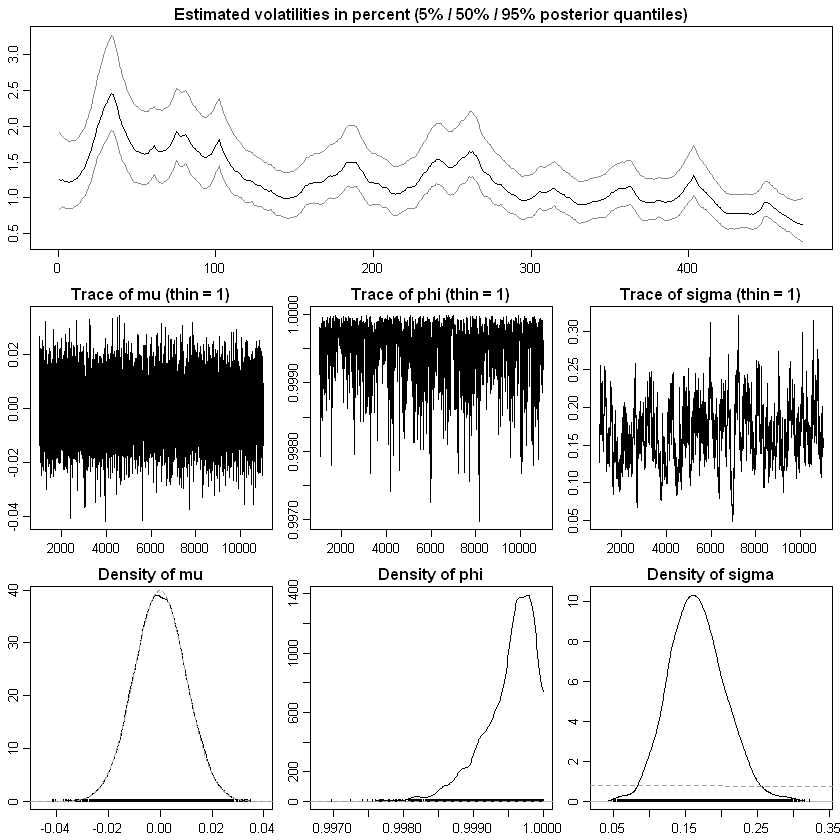

In [140]:
# fit model
#### ARIMA(0,0,0), ARIMA(1,0,1), ARIMA(0,0,1), ARIMA(1,0,0)
p_values <- 0:1
d_value <- 0
q_values <- 0:1 

return_list <- list()
model_index <- 1

for (p in p_values) {
  for (q in q_values) {
    if ((p == 1 && q == 1) || (p == 0 && q == 1) || (p == 1 && q == 0) || (p == 0 && q == 0)) {
      model <- arima(x = log_return, order = c(p, d_value, q))
      return_list[[model_index]] <- model
      model_index <- model_index + 1
      
      cat("Call:\n")
      cat(paste("arima(x = log_return, order = c(", p, ", ", d_value, ", ", q, "))\n", sep=""))
      cat("\nCoefficients:\n")
      print(coef(summary(model)))
      cat("\nsigma^2 estimated as ", model$sigma2,
          ":  log likelihood = ", logLik(model),
          ",  aic = ", AIC(model), "\n\n", sep="")
    }
  }
}

# model checking
# Perform the Ljung-Box test on the residuals of the fitted ARIMA model
ljung_box_results <- vector("list", length(return_list))
for (i in 1:length(return_list)) {
  ljung_box_results[[i]] <- Box.test(return_list[[i]]$residuals, lag = 12, type = "Ljung-Box")
  cat(paste("Model", i, ":\n"))
  cat(paste("data:  est_a_list[[", i, "]]$residuals\n", sep = ""))
  cat(paste("X-squared = ", round(ljung_box_results[[i]]$statistic, 4), ", df = ", ljung_box_results[[i]]$parameter, ", p-value = ", round(ljung_box_results[[i]]$p.value, 4), "\n\n", sep = ""))
}
###Given that the p-value is much higher than the common significance levels 0.05, we would not reject the null hypothesis at these levels. This suggests that the model has adequately captured the time series' structure and that the residuals are behaving like white noise.

# model selection
min_aic <- Inf
min_bic <- Inf
min_aic_index <- NA
min_bic_index <- NA

# Loop through each model to calculate and print AIC and BIC
for (i in 1:length(return_list)) {
  current_aic <- AIC(return_list[[i]])
  current_bic <- BIC(return_list[[i]])
  cat(sprintf("Model %d: AIC = %f, BIC = %f\n", i, current_aic, current_bic))
  if (current_aic < min_aic) {
    min_aic <- current_aic
    min_aic_index <- i
  }
  if (current_bic < min_bic) {
    min_bic <- current_bic
    min_bic_index <- i
  }
}
cat(sprintf("Model with the smallest AIC is Model %d with AIC = %f\n", min_aic_index, min_aic))
cat(sprintf("Model with the smallest BIC is Model %d with BIC = %f\n", min_bic_index, min_bic))
# aic: model_3: ARIMA(1, 0, 0)
# bic: model_1: ARIMA(0, 0, 0)
##choose model_1: ARIMA(0, 0, 0)

# fit model & model checking
# GARCH(1,1) - std
library("fGarch")
garch11 =garchFit(w2~arma(0,0)+garch(1,1),data=log_return,include.mean = FALSE,trace=F,cond.dist = c("std"))
summary(garch11)
# Estimate  Std. Error  t value Pr(>|t|)    
# omega  9.142e-06   6.264e-06    1.459  0.14444    
# alpha1 9.313e-02   3.617e-02    2.575  0.01003 *  
# beta1  8.555e-01   5.845e-02   14.637  < 2e-16 ***
# shape  7.999e+00   2.683e+00    2.981  0.00287 **
res_garch11=residuals(garch11,standardize=T)
test1_garch11 <- Box.test(res_garch11, lag = 12, type = "Ljung")
test2_garch11 <- Box.test(res_garch11^2, lag = 12, type = "Ljung")
print(test1_garch11)
# Box-Ljung test
# data:  res_garch11
# X-squared = 7.2731, df = 12, p-value = 0.8391
print(test2_garch11)
# Box-Ljung test
# data:  res_garch11^2
# X-squared = 9.9411, df = 12, p-value = 0.6211
pv1_garch11=1-pchisq(test1_garch11$statistic,12)
pv2_garch11=1-pchisq(test2_garch11$statistic,12)
print(unname(pv1_garch11)) # 0.8390528
print(unname(pv2_garch11)) # 0.6211309
aic_garch11 <- garch11@fit$ics["AIC"]
bic_garch11 <- garch11@fit$ics["BIC"]
print(aic_garch11) # -5.895495
print(bic_garch11) # -5.860266


# s-Garch(1,1)
# without omega
library(rugarch)
# Define Garch Model and assume omega=0
spec_sGARCH11 <- ugarchspec(variance.model = list(model = "sGARCH", 
                                                  garchOrder = c(1, 1), 
                                                  submodel = NULL, 
                                                  external.regressors = NULL, 
                                                  variance.targeting = FALSE), 
                            mean.model = list(armaOrder = c(0, 0), 
                                              include.mean = F), 
                            fixed.pars = list(omega = 0),distribution.model="std")
model_sGARCH11 <- ugarchfit(spec = spec_sGARCH11, data = log_return)
show(model_sGARCH11)
# Estimate  Std. Error  t value Pr(>|t|)
# omega   0.000000          NA       NA       NA
# alpha1  0.055137    0.025513   2.1611 0.030685
# beta1   0.943863    0.023901  39.4911 0.000000
# shape   8.573688    2.883314   2.9736 0.002944
res_sGARCH11=residuals(model_sGARCH11,standardize=T)
test1_sGARCH11 = Box.test(res_sGARCH11,12,type="Ljung")
test2_sGARCH11 = Box.test(res_sGARCH11^2,12,type="Ljung")
test1_sGARCH11
# Box-Ljung test
# data:  res_sGARCH11
# X-squared = 7.7718, df = 12, p-value = 0.8027
test2_sGARCH11
# Box-Ljung test
# data:  res_sGARCH11^2
# X-squared = 9.4483, df = 12, p-value = 0.6642
pv1_sGARCH11=1-pchisq(test1_sGARCH11$statistic,12)
pv2_sGARCH11=1-pchisq(test2_sGARCH11$statistic,12)
print(unname(pv1_sGARCH11)) # 0.8027032
print(unname(pv2_sGARCH11)) # 0.6642384
aic_sGARCH11 = infocriteria(model_sGARCH11)[1]
bic_sGARCH11 = infocriteria(model_sGARCH11)[2]
print(aic_sGARCH11) # -5.886253
print(bic_sGARCH11) # -5.859831


# GARCH(2,1) - std
garch21 =garchFit(w2~arma(0,0)+garch(2,1),data=log_return,include.mean = FALSE,trace=F,cond.dist = c("std"))
summary(garch21)
# Estimate  Std. Error  t value Pr(>|t|)    
# omega  1.656e-05   1.014e-05    1.633  0.10239    
# alpha1 5.216e-03   4.733e-02    0.110  0.91225    
# alpha2 1.491e-01   8.078e-02    1.846  0.06496 .  
# beta1  7.546e-01   9.896e-02    7.625 2.44e-14 ***
# shape  9.102e+00   3.501e+00    2.600  0.00933 ** 
res_garch21=residuals(garch21,standardize=T)
test1_garch21 <- Box.test(res_garch21, lag = 12, type = "Ljung")
test2_garch21 <- Box.test(res_garch21^2, lag = 12, type = "Ljung")
print(test1_garch21)
# Box-Ljung test
# data:  res_garch21
# X-squared = 7.435, df = 12, p-value = 0.8276
print(test2_garch21)
# Box-Ljung test
# data:  res_garch21^2
# X-squared = 9.2565, df = 12, p-value = 0.6809
pv1_garch21=1-pchisq(test1_garch21$statistic,12)
pv2_garch21=1-pchisq(test2_garch21$statistic,12)
print(unname(pv1_garch21)) # 0.8275817
print(unname(pv2_garch21)) # 0.6808782
aic_garch21 <- garch21@fit$ics["AIC"]
bic_garch21 <- garch21@fit$ics["BIC"]
print(aic_garch21) # -5.897808   
print(bic_garch21) # -5.853772
# alpha1 and alpha2 are not statistically significant, especially the contribution of alpha2 is almost negligible, abandon the model


# GARCH(1,2) - std
garch12 =garchFit(w2~arma(0,0)+garch(1,2),data=log_return,include.mean = FALSE,trace=F,cond.dist = c("std"))
summary(garch12)
# Estimate  Std. Error  t value Pr(>|t|)   
# omega  9.135e-06   6.652e-06    1.373  0.16968   
# alpha1 9.317e-02   4.616e-02    2.019  0.04353 * 
# beta1  8.555e-01   6.394e-01    1.338  0.18092   
# beta2  1.000e-08   5.955e-01    0.000  1.00000   
# shape  7.989e+00   2.706e+00    2.953  0.00315 **
res_garch12=residuals(garch12,standardize=T)
test1_garch12 <- Box.test(res_garch12, lag = 12, type = "Ljung")
test2_garch12 <- Box.test(res_garch12^2, lag = 12, type = "Ljung")
print(test1_garch12)
# Box-Ljung test
# data:  res_garch12
# X-squared = 7.2909, df = 12, p-value = 0.8378
print(test2_garch12)
# Box-Ljung test
# data:  res_garch12^2
# X-squared = 9.9531, df = 12, p-value = 0.6201
pv1_garch12=1-pchisq(test1_garch12$statistic,12)
pv2_garch12=1-pchisq(test2_garch12$statistic,12)
print(unname(pv1_garch12))# 0.837803
print(unname(pv2_garch12))# 0.6200716
aic_garch12 <- garch12@fit$ics["AIC"]
bic_garch12 <- garch12@fit$ics["BIC"]
print(aic_garch12)# -5.891227  
print(bic_garch12)# -5.847191 
# alpha and beta are not statistically significant, especially the contribution of alpha2 is almost negligible, abandon the model


# ARCH(1)+ARMA(0,0) ( GARCH(1,0)+ARMA(0,0))
garch10 = garchFit(sample~arma(0,0)+garch(1,0),data=log_return,trace=F,include.mean=F,cond.dist="std")
summary(garch10)
# Estimate  Std. Error  t value Pr(>|t|)    
# omega  1.564e-04   1.788e-05    8.744  < 2e-16 ***
# alpha1 1.321e-01   6.571e-02    2.010  0.04441 *  
# shape  5.867e+00   1.554e+00    3.775  0.00016 ***
res_garch10=residuals(garch10,standardize=T)
test1_garch10 <- Box.test(res_garch10, lag = 12, type = "Ljung")
test2_garch10 <- Box.test(res_garch10^2, lag = 12, type = "Ljung")
print(test1_garch10)
# Box-Ljung test
# data:  res_garch10
# X-squared = 10.076, df = 12, p-value = 0.6093
print(test2_garch10)
# Box-Ljung test
# data:  res_garch10^2
# X-squared = 37.302, df = 12, p-value = 0.0001995
pv1_garch10=1-pchisq(test1_garch10$statistic,12)
pv2_garch10=1-pchisq(test2_garch10$statistic,12)
print(unname(pv1_garch10))# 0.6092888
print(unname(pv2_garch10))# 0.0001995425
aic_garch10 <- garch10@fit$ics["AIC"]
bic_garch10 <- garch10@fit$ics["BIC"]
print(aic_garch10)# -5.856012 
print(bic_garch10)# -5.829591 
# can't pass


# ARCH(2)+ARMA(0,0)
#GARCH(2,0)+ARMA(0,0)=ARCH(2)
garch20=garchFit(sample~arma(0,0)+garch(2,0),data=log_return,trace=F,include.mean=F,cond.dist = "std")
summary(garch20)
# Estimate  Std. Error  t value Pr(>|t|)    
# omega  1.322e-04   1.586e-05    8.341  < 2e-16 ***
# alpha1 5.375e-02   5.671e-02    0.948  0.34329    
# alpha2 1.997e-01   8.053e-02    2.480  0.01312 *  
# shape  6.975e+00   2.132e+00    3.272  0.00107 ** 
res_garch20=residuals(garch20,standardize=T)
test1_garch20 <- Box.test(res_garch20, lag = 12, type = "Ljung")
test2_garch20 <- Box.test(res_garch20^2, lag = 12, type = "Ljung")
print(test1_garch20)
# Box-Ljung test
# data:  res_garch20
# X-squared = 9.3057, df = 12, p-value = 0.6766
print(test2_garch20)
# Box-Ljung test
# data:  res_garch20^2
# X-squared = 37.517, df = 12, p-value = 0.0001841
pv1_garch20=1-pchisq(test1_garch20$statistic,12)
pv2_garch20=1-pchisq(test2_garch20$statistic,12)
print(unname(pv1_garch20))# 0.676622
print(unname(pv2_garch20))# 0.0001841476
aic_garch20 <- garch20@fit$ics["AIC"]
bic_garch20 <- garch20@fit$ics["BIC"]
print(aic_garch20)# -5.872784
print(bic_garch20)# -5.837555 
#### can't pass

# ARCH(3)+ARMA(0,0)
# GARCH(3,0)+ARMA(0,0)=ARCH(3)
garch30=garchFit(sample~arma(0,0)+garch(3,0),data=log_return,trace=F,include.mean=FALSE)
summary(garch30)
# Estimate  Std. Error  t value Pr(>|t|)    
# omega  1.066e-04   1.317e-05    8.090 6.66e-16 ***
# alpha1 2.351e-02   5.228e-02    0.450 0.652916    
# alpha2 2.148e-01   6.399e-02    3.357 0.000789 ***
# alpha3 1.739e-01   6.245e-02    2.784 0.005362 ** 
res_garch30=residuals(garch30,standardize=T)
test1_garch30 <- Box.test(res_garch30, lag = 12, type = "Ljung")
test2_garch30 <- Box.test(res_garch30^2, lag = 12, type = "Ljung")
print(test1_garch30)
# Box-Ljung test
# data:  res_garch30
# X-squared = 8.8538, df = 12, p-value = 0.7154
print(test2_garch30)
# Box-Ljung test
# data:  res_garch30^2
# X-squared = 41.626, df = 12, p-value = 3.849e-05
pv1_garch30=1-pchisq(test1_garch30$statistic,12)
pv2_garch30=1-pchisq(test2_garch30$statistic,12)
print(unname(pv1_garch30))# 0.7153621
print(unname(pv2_garch30))# 3.849435e-05
aic_garch30 <- garch30@fit$ics["AIC"]
bic_garch30 <- garch30@fit$ics["BIC"]
print(aic_garch30)# -5.859336  
print(bic_garch30)# -5.824108
#### can't pass



# iGARCH(1,1)
spec_iGARCH11<-ugarchspec(variance.model=list(model="iGARCH",garchOrder=c(1,1)),mean.model=list(armaOrder=c(0,0),include.mean=F),distribution.model="std")
model_iGARCH11<-ugarchfit(spec=spec_iGARCH11,data=log_return)
model_iGARCH11
# Estimate  Std. Error  t value Pr(>|t|)
# omega   0.000003    0.000008  0.35282 0.724225
# alpha1  0.108267    0.070752  1.53024 0.125957
# beta1   0.891733          NA       NA       NA
# shape   6.801623    1.502390  4.52720 0.000006
res_iGARCH11=residuals(model_iGARCH11,standardize=T)
test1_iGARCH11 = Box.test(res_iGARCH11,12,type="Ljung")
test2_iGARCH11 = Box.test(res_iGARCH11^2,12,type="Ljung")
test1_iGARCH11
# Box-Ljung test
# data:  res_iGARCH11
# X-squared = 7.0932, df = 12, p-value = 0.8514
test2_iGARCH11
# Box-Ljung test
# data:  res_iGARCH11^2
# X-squared = 8.1688, df = 12, p-value = 0.7718
pv1_iGARCH11=1-pchisq(test1_iGARCH11$statistic,12)
pv2_iGARCH11=1-pchisq(test2_iGARCH11$statistic,12)
print(unname(pv1_iGARCH11)) # 0.8513941
print(unname(pv2_iGARCH11)) # 0.7718074
aic_iGARCH11 = infocriteria(model_iGARCH11)[1]
bic_iGARCH11 = infocriteria(model_iGARCH11)[2]
print(aic_iGARCH11) # -5.892413
print(bic_iGARCH11) # -5.865992
# omega, alpha1 insignificant


# GARCH-M(1,1)+ARMA(0,0)
# with omega
condVar <- sigma(model_iGARCH11)
spec_GarchM11 <- ugarchspec(variance.model = list(model = "iGARCH", garchOrder = c(1, 1)),
                            mean.model = list(armaOrder = c(0, 0), include.mean = T, 
                                              external.regressors = matrix(condVar)),
                            distribution.model = "std")
model_GarchM11<-ugarchfit(spec=spec_GarchM11,data=log_return)
model_GarchM11
# Estimate  Std. Error  t value Pr(>|t|)
# mu     -0.003354    0.002131 -1.57419 0.115443
# mxreg1  0.258214    0.167106  1.54521 0.122296
# omega   0.000003    0.000008  0.33474 0.737823
# alpha1  0.107558    0.072980  1.47381 0.140534
# beta1   0.892442          NA       NA       NA
# shape   6.873062    1.571863  4.37256 0.000012
res_GarchM11=residuals(model_GarchM11,standardize=T)
test1_GarchM11 = Box.test(res_GarchM11,12,type="Ljung")
test2_GarchM11 = Box.test(res_GarchM11^2,12,type="Ljung")
test1_GarchM11
# Box-Ljung test
# data:  res_GarchM11
# X-squared = 7.4945, df = 12, p-value = 0.8233
test2_GarchM11
# Box-Ljung test
# data:  res_GarchM11^2
# X-squared = 9.2691, df = 12, p-value = 0.6798
pv1_GarchM11=1-pchisq(test1_GarchM11$statistic,12)
pv2_GarchM11=1-pchisq(test2_GarchM11$statistic,12)
print(unname(pv1_GarchM11)) # 0.8232812
print(unname(pv2_GarchM11)) # 0.6797932
aic_GarchM11 = infocriteria(model_GarchM11)[1]
bic_GarchM11 = infocriteria(model_GarchM11)[2]
print(aic_GarchM11) # -5.88921
print(bic_GarchM11) # -5.845174
# all insignificant


# eGARCH(1,1)
# with alpha
spec_eGARCH11=ugarchspec(variance.model=list(model="eGARCH",garchOrder=c(1,1)),mean.model=list(armaOrder=c(0,0),include.mean=FALSE),distribution.model="std")
model_eGARCH11=ugarchfit(spec=spec_eGARCH11,data=log_return)
model_eGARCH11
# Estimate  Std. Error   t value Pr(>|t|)
# omega  -0.363377    0.071133  -5.10839 0.000000
# alpha1 -0.019826    0.032414  -0.61165 0.540770
# beta1   0.958424    0.008089 118.47905 0.000000
# gamma1  0.176054    0.065210   2.69981 0.006938
# shape   7.686119    2.523722   3.04555 0.002323
res_eGARCH11=residuals(model_eGARCH11,standardize=T)
test1_eGARCH11 = Box.test(res_eGARCH11,12,type="Ljung")
test2_eGARCH11 = Box.test(res_eGARCH11^2,12,type="Ljung")
test1_eGARCH11
# Box-Ljung test
# data:  res_eGARCH11
# X-squared = 7.3958, df = 12, p-value = 0.8304
test2_eGARCH11
# Box-Ljung test
# data:  res_eGARCH11^2
# X-squared = 12.432, df = 12, p-value = 0.4116
pv1_eGARCH11=1-pchisq(test1_eGARCH11$statistic,12)
pv2_eGARCH11=1-pchisq(test2_eGARCH11$statistic,12)
print(unname(pv1_eGARCH11)) # 0.8303917
print(unname(pv2_eGARCH11)) # 0.4116453
aic_eGARCH11 = infocriteria(model_eGARCH11)[1]
bic_eGARCH11 = infocriteria(model_eGARCH11)[2]
print(aic_eGARCH11) # -5.886235
print(bic_eGARCH11) # -5.8422

# without alpha
spec_eGARCH11_2=ugarchspec(variance.model=list(model="eGARCH",garchOrder=c(1,1)),mean.model=list(armaOrder=c(0,0),include.mean=FALSE),distribution.model="std", fixed.pars = list(alpha1 = 0))
model_eGARCH11_2=ugarchfit(spec=spec_eGARCH11_2,data=log_return)
model_eGARCH11_2
# Estimate  Std. Error  t value Pr(>|t|)
# omega   -0.41478    0.088495  -4.6871 0.000003
# alpha1   0.00000          NA       NA       NA
# beta1    0.95246    0.010083  94.4657 0.000000
# gamma1   0.18853    0.061662   3.0575 0.002232
# shape    7.71461    2.522213   3.0587 0.002223
res_eGARCH11_2=residuals(model_eGARCH11_2,standardize=T)
test1_eGARCH11_2 = Box.test(res_eGARCH11_2,12,type="Ljung")
test2_eGARCH11_2 = Box.test(res_eGARCH11_2^2,12,type="Ljung")
test1_eGARCH11_2
# Box-Ljung test
# data:  res_eGARCH11_2
# X-squared = 7.5352, df = 12, p-value = 0.8203
test2_eGARCH11_2
# Box-Ljung test
# data:  res_eGARCH11_2^2
# X-squared = 13.536, df = 12, p-value = 0.3313
pv1_eGARCH11_2=1-pchisq(test1_eGARCH11_2$statistic,12)
pv2_eGARCH11_2=1-pchisq(test2_eGARCH11_2$statistic,12)
print(unname(pv1_eGARCH11_2)) # 0.8203171
print(unname(pv2_eGARCH11_2)) # 0.331334
aic_eGARCH11_2 = infocriteria(model_eGARCH11_2)[1]
bic_eGARCH11_2 = infocriteria(model_eGARCH11_2)[2]
print(aic_eGARCH11_2) # -5.88976
print(bic_eGARCH11_2) # -5.854531

# gjrGARCH(1,1)
# with gamma1
spec_gjrGARCH11=ugarchspec(variance.model=list(model="gjrGARCH",garchOrder=c(1,1)),mean.model=list(armaOrder=c(0,0),include.mean=FALSE),distribution.model="std")
model_gjrGARCH11=ugarchfit(spec=spec_gjrGARCH11,data=log_return)
model_gjrGARCH11
# Estimate  Std. Error  t value Pr(>|t|)
# omega   0.000009    0.000002  5.12138 0.000000
# alpha1  0.079482    0.031965  2.48654 0.012899
# beta1   0.862302    0.026738 32.25018 0.000000
# gamma1  0.018152    0.049164  0.36922 0.711962
# shape   7.969975    2.536995  3.14150 0.001681
res_gjrGARCH11=residuals(model_gjrGARCH11,standardize=T)
test1_gjrGARCH11 = Box.test(res_gjrGARCH11,12,type="Ljung")
test2_gjrGARCH11 = Box.test(res_gjrGARCH11^2,12,type="Ljung")
test1_gjrGARCH11
# Box-Ljung test
# data:  res_gjrGARCH11
# X-squared = 7.1539, df = 12, p-value = 0.8473
test2_gjrGARCH11
# Box-Ljung test
# data:  res_gjrGARCH11^2
# X-squared = 9.2814, df = 12, p-value = 0.6787
pv1_gjrGARCH11=1-pchisq(test1_gjrGARCH11$statistic,12)
pv2_gjrGARCH11=1-pchisq(test2_gjrGARCH11$statistic,12)
print(unname(pv1_gjrGARCH11)) # 0.8472796
print(unname(pv2_gjrGARCH11)) # 0.6787252
aic_gjrGARCH11 = infocriteria(model_gjrGARCH11)[1]
bic_gjrGARCH11 = infocriteria(model_gjrGARCH11)[2]
print(aic_gjrGARCH11) # -5.891519
print(bic_gjrGARCH11) # -5.847483

# without gamma1
spec_gjrGARCH11_2=ugarchspec(variance.model=list(model="gjrGARCH",garchOrder=c(1,1)),mean.model=list(armaOrder=c(0,0),include.mean=FALSE),distribution.model="std", fixed.pars = list(gamma1=0))
model_gjrGARCH11_2=ugarchfit(spec=spec_gjrGARCH11_2,data=log_return)
model_gjrGARCH11_2
# Estimate  Std. Error  t value Pr(>|t|)
# omega   0.000009    0.000002   5.4946 0.000000
# alpha1  0.092988    0.015844   5.8689 0.000000
# beta1   0.856075    0.026789  31.9557 0.000000
# gamma1  0.000000          NA       NA       NA
# shape   7.996378    2.547107   3.1394 0.001693
res_gjrGARCH11_2=residuals(model_gjrGARCH11_2,standardize=T)
test1_gjrGARCH11_2 = Box.test(res_gjrGARCH11_2,12,type="Ljung")
test2_gjrGARCH11_2 = Box.test(res_gjrGARCH11_2^2,12,type="Ljung")
test1_gjrGARCH11_2
# Box-Ljung test
# data:  res_gjrGARCH11_2
# X-squared = 7.2708, df = 12, p-value = 0.8392
test2_gjrGARCH11_2
# Box-Ljung test
# data:  res_gjrGARCH11_2^2
# X-squared = 9.9228, df = 12, p-value = 0.6227
pv1_gjrGARCH11_2=1-pchisq(test1_gjrGARCH11_2$statistic,12)
pv2_gjrGARCH11_2=1-pchisq(test2_gjrGARCH11_2$statistic,12)
print(unname(pv1_gjrGARCH11_2)) # 0.8392129
print(unname(pv2_gjrGARCH11_2)) # 0.6227366
aic_gjrGARCH11_2 = infocriteria(model_gjrGARCH11_2)[1]
bic_gjrGARCH11_2 = infocriteria(model_gjrGARCH11_2)[2]
print(aic_gjrGARCH11_2) # -5.895494
print(bic_gjrGARCH11_2) # -5.860265


# apARCH(1,1)
spec_apARCH11=ugarchspec(variance.model=list(model="apARCH",garchOrder=c(1,1)),mean.model=list(armaOrder=c(0,0),include.mean=FALSE),distribution.model="std")
model_apARCH11=ugarchfit(spec=spec_apARCH11,data=log_return)
model_apARCH11
# Estimate  Std. Error   t value Pr(>|t|)
# omega   0.000000    0.000002  0.068977  0.94501
# alpha1  0.069958    0.070518  0.992062  0.32117
# beta1   0.847178    0.096717  8.759344  0.00000
# gamma1  0.010984    0.138322  0.079407  0.93671
# delta   2.979132    0.176943 16.836716  0.00000
# shape   7.300580    2.686640  2.717365  0.00658
res_apARCH11=residuals(model_apARCH11,standardize=T)
test1_apARCH11 = Box.test(res_apARCH11,12,type="Ljung")
test2_apARCH11 = Box.test(res_apARCH11^2,12,type="Ljung")
test1_apARCH11
# Box-Ljung test
# data:  res_apARCH11
# X-squared = 7.2467, df = 12, p-value = 0.8409
test2_apARCH11
# Box-Ljung test
# data:  res_apARCH11^2
# X-squared = 7.3374, df = 12, p-value = 0.8345
pv1_apARCH11=1-pchisq(test1_apARCH11$statistic,12)
pv2_apARCH11=1-pchisq(test2_apARCH11$statistic,12)
print(unname(pv1_apARCH11)) # 0.8408869
print(unname(pv2_apARCH11)) # 0.8345338
aic_apARCH11 = infocriteria(model_apARCH11)[1]
bic_apARCH11 = infocriteria(model_apARCH11)[2]
print(aic_apARCH11)# -5.885201
print(bic_apARCH11)# -5.832358
# alpha,gamma insignificant


# csGARCH(1,1)
# with omega
spec_csGARCH11=ugarchspec(variance.model = list(model = "csGARCH", garchOrder = c(1,1)),mean.model = list(armaOrder = c(0,0), include.mean = FALSE,distribution.model="std"))
model_csGARCH11=ugarchfit(spec=spec_csGARCH11,data=log_return)
model_csGARCH11
# Estimate  Std. Error    t value Pr(>|t|)
# omega   0.000000    0.000000    0.20872 0.834667
# alpha1  0.099734    0.037670    2.64755 0.008108
# beta1   0.734265    0.088186    8.32630 0.000000
# eta11   0.999891    0.000935 1069.03129 0.000000
# eta21   0.025746    0.001410   18.25723 0.000000
res_csGARCH11=residuals(model_csGARCH11,standardize=T)
test1_csGARCH11 = Box.test(res_csGARCH11,12,type="Ljung")
test2_csGARCH11 = Box.test(res_csGARCH11^2,12,type="Ljung")
test1_csGARCH11
# Box-Ljung test
# data:  res_csGARCH11
# X-squared = 9.0801, df = 12, p-value = 0.6961
test2_csGARCH11
# Box-Ljung test
# data:  res_csGARCH11^2
# X-squared = 10.492, df = 12, p-value = 0.5729
pv1_csGARCH11=1-pchisq(test1_csGARCH11$statistic,12)
pv2_csGARCH11=1-pchisq(test2_csGARCH11$statistic,12)
print(unname(pv1_csGARCH11))# 0.6960732
print(unname(pv2_csGARCH11))# 0.5728769
aic_csGARCH11 = infocriteria(model_csGARCH11)[1]
bic_csGARCH11 = infocriteria(model_csGARCH11)[2]
print(aic_csGARCH11)# -5.873025
print(bic_csGARCH11)# -5.828989


# without omega
spec_csGARCH11_2 <- ugarchspec(variance.model = list(model = "csGARCH", garchOrder = c(1, 1)),
                               mean.model = list(armaOrder = c(0, 0), include.mean = FALSE,distribution.model = "std"),
                               fixed.pars = list(omega = 0))
model_csGARCH11_2 <- ugarchfit(spec = spec_csGARCH11_2, data = log_return)
model_csGARCH11_2
# Estimate  Std. Error   t value Pr(>|t|)
# omega   0.000000          NA        NA       NA
# alpha1  0.039037    0.000853  45.75361  0.00000
# beta1   0.960963    0.002143 448.32142  0.00000
# eta11   1.000000    0.002038 490.67211  0.00000
# eta21   0.008682    0.012927   0.67161  0.50184
res_csGARCH11_2=residuals(model_csGARCH11_2,standardize=T)
test1_csGARCH11_2 = Box.test(res_csGARCH11_2,12,type="Ljung")
test2_csGARCH11_2 = Box.test(res_csGARCH11_2^2,12,type="Ljung")
test1_csGARCH11_2
# Box-Ljung test
# data:  res_csGARCH11
# X-squared = 8.0233, df = 12, p-value = 0.7833
test2_csGARCH11_2
# Box-Ljung test
# data:  res_csGARCH11^2
# X-squared = 11.612, df = 12, p-value = 0.4773
pv1_csGARCH11_2=1-pchisq(test1_csGARCH11_2$statistic,12)
pv2_csGARCH11_2=1-pchisq(test2_csGARCH11_2$statistic,12)
print(unname(pv1_csGARCH11_2))# 0.7833107
print(unname(pv2_csGARCH11_2))# 0.4772821
aic_csGARCH11_2 = infocriteria(model_csGARCH11_2)[1]
bic_csGARCH11_2 = infocriteria(model_csGARCH11_2)[2]
print(aic_csGARCH11_2)# -5.855314
print(bic_csGARCH11_2)# -5.820085

# fiGARCH(1,1)
# with alpha1
spec_fiGARCH11=ugarchspec(variance.model = list(model = "fiGARCH", garchOrder = c(1,1)),mean.model = list(armaOrder = c(0,0), include.mean = FALSE,distribution.model="std"))
model_fiGARCH11=ugarchfit(spec=spec_fiGARCH11,data=log_return)
model_fiGARCH11
# Estimate  Std. Error  t value Pr(>|t|)
# omega   0.000008    0.000008 0.949994 0.342115
# alpha1  0.000000    0.197007 0.000001 0.999999
# beta1   0.329888    0.185190 1.781349 0.074856
# delta   0.350971    0.096571 3.634336 0.000279
res_fiGARCH11=residuals(model_fiGARCH11,standardize=T)
test1_fiGARCH11 = Box.test(res_fiGARCH11,12,type="Ljung")
test2_fiGARCH11 = Box.test(res_fiGARCH11^2,12,type="Ljung")
test1_fiGARCH11
# Box-Ljung test
# data:  res_fiGARCH11
# X-squared = 7.6227, df = 12, p-value = 0.8139
test2_fiGARCH11
# Box-Ljung test
# data:  res_fiGARCH11^2
# X-squared = 8.114, df = 12, p-value = 0.7762
pv1_fiGARCH11=1-pchisq(test1_fiGARCH11$statistic,12)
pv2_fiGARCH11=1-pchisq(test2_fiGARCH11$statistic,12)
print(unname(pv1_fiGARCH11))# 0.8138753
print(unname(pv2_fiGARCH11))# 0.7761614
aic_fiGARCH11 = infocriteria(model_fiGARCH11)[1]
bic_fiGARCH11 = infocriteria(model_fiGARCH11)[2]
print(aic_fiGARCH11) # -5.885236
print(bic_fiGARCH11) # -5.850008


# Stochastic Volatility Model
library(stochvol)
model_sto <- svsample(log_return, priormu = c(mean(log_return), 0.01))
summary(model_sto)
# Posterior draws of SV parameters (thinning = 1):
# mean      sd      5%     50%   95%   ESS
# mu        -0.00032 0.01007 -0.0171 -0.0004 0.016 10000
# phi        0.99947 0.00044  0.9986  0.9996 1.000   289
# sigma      0.16859 0.04743  0.0976  0.1636 0.252    75
# exp(mu/2)  0.99985 0.00503  0.9915  0.9998 1.008 10000
# sigma^2    0.03067 0.01735  0.0095  0.0268 0.063    75
plot(model_sto)


# Threshold ARIMA
###method 2: scatter-line plot
library("quantmod")
library("tsDyn")
library("stats")
library("nonlinearTseries")
library("datasets")
library("NTS")
{#par(mfrow=c(2,2))
  scatter.smooth(Lag(log_return, 1), log_return, span = 2/3, degree = 1,
                 family = c("symmetric", "gaussian"), evaluation = 50, 
                 xlab = "t-1", ylab = "t")
  scatter.smooth(Lag(log_return, 2), log_return, span = 2/3, degree = 1,
                 family = c("symmetric", "gaussian"), evaluation = 50, 
                 xlab = "t-2", ylab = "t")
  scatter.smooth(Lag(log_return, 3), log_return, span = 2/3, degree = 1,
                 family = c("symmetric", "gaussian"), evaluation = 50, 
                 xlab = "t-3", ylab = "t")
  scatter.smooth(Lag(log_return, 4), log_return, span = 2/3, degree = 1,
                 family = c("symmetric", "gaussian"), evaluation = 50, 
                 xlab = "t-4", ylab = "t")
}
# 1. Scatter Points: It is a proof of white noise.
# 2. Line: It seems like there is no non-linear relationship between parameters.

###method3: statistical test:
####Sometimes however it happens so, that it’s not that simple to decide whether this type of nonlinearity is present. In this case, we’d have to run a statistical test — this approach is the most recommended by both Hansen’s and Tsay’s procedures. In order to do it, however, it’s good to first establish what lag order we are more or less talking about. We will use Average Mutual Information for this, and we will limit the order to its first local minimum
mutualInformation(log_return)
# $time.lag
# [1]  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21
# 
# $mutual.information
# [1] 1.25123002 0.04356863 0.06011789 0.06267785 0.04400219 0.05864458 0.05871319 0.03874690
# [9] 0.05021785 0.04852825 0.04163651 0.06049566 0.03714234 0.02753486 0.04735917 0.03751023
# [17] 0.03756610 0.04185142 0.03304839 0.03437464 0.04230189 0.04910079
# 
# $units
# [1] "Nats"
# 
# $n.partitions
# [1] 7
# 
# attr(,"class")
# [1] "mutualInf"
####according to the above figure, which shows the relation in entropy dimension. It's an indicator about their correlation. Another evidence of White Noise>>NOT NEED TO CHECK WHETHER IT IS STEAR OR AR!!!


## Without Considering HETEROPART
# checking the order
## Method 1:
for (d in 1:3){
  for (p in 1:3){
    test_result <- thr.test(log_return, p=p, d=d)
    F_ratio <- test_result$F.ratio
    df1 <- test_result$df[1]
    df2 <- test_result$df[2]
    p_value <- 1 - pf(F_ratio, df1, df2)  # 计算 p-value
    cat("p = ", p, " d = ", d, " F-ratio = ", F_ratio, " P-value = ", p_value, "\n")
  }
}
# SETAR model is entertained 
# Threshold nonlinearity test for (p,d):  1 1 
# F-ratio and p-value:  2.019124 0.1340315 
# p =  1  d =  1  F-ratio =  2.019124  P-value =  0.1340315 
# SETAR model is entertained 
# Threshold nonlinearity test for (p,d):  2 1 
# F-ratio and p-value:  2.47345 0.06112494 
# p =  2  d =  1  F-ratio =  2.47345  P-value =  0.06112494 
# SETAR model is entertained 
# Threshold nonlinearity test for (p,d):  3 1 
# F-ratio and p-value:  1.902326 0.109106 
# p =  3  d =  1  F-ratio =  1.902326  P-value =  0.109106 
# SETAR model is entertained 
# Threshold nonlinearity test for (p,d):  1 2 
# F-ratio and p-value:  1.172376 0.3106228 
# p =  1  d =  2  F-ratio =  1.172376  P-value =  0.3106228 
# SETAR model is entertained 
# Threshold nonlinearity test for (p,d):  2 2 
# F-ratio and p-value:  0.8728394 0.4551147 
# p =  2  d =  2  F-ratio =  0.8728394  P-value =  0.4551147 
# SETAR model is entertained 
# Threshold nonlinearity test for (p,d):  3 2 
# F-ratio and p-value:  0.8072895 0.5209817 
# p =  3  d =  2  F-ratio =  0.8072895  P-value =  0.5209817 
# SETAR model is entertained 
# Threshold nonlinearity test for (p,d):  1 3 
# F-ratio and p-value:  1.510815 0.2219075 
# p =  1  d =  3  F-ratio =  1.510815  P-value =  0.2219075 
# SETAR model is entertained 
# Threshold nonlinearity test for (p,d):  2 3 
# F-ratio and p-value:  0.9510905 0.4158064 
# p =  2  d =  3  F-ratio =  0.9510905  P-value =  0.4158064 
# SETAR model is entertained 
# Threshold nonlinearity test for (p,d):  3 3 
# F-ratio and p-value:  1.580358 0.1785389 
# p =  3  d =  3  F-ratio =  1.580358  P-value =  0.1785389 
#### No combination of parameters showed significant nonlinearity of the model.
####TAR model is not applicable

In [141]:
# model selection
aic_values <- c(sGARCH11_no_omega = aic_sGARCH11, eGARCH11_no_alpha = aic_eGARCH11_2, gjrGARCH11_no_gamma1 = aic_gjrGARCH11_2)
best_aic_name <- names(which.min(aic_values))
best_aic_value <- min(aic_values)

bic_values <- c(sGARCH11_no_omega = bic_sGARCH11, eGARCH11_no_alpha = bic_eGARCH11_2, gjrGARCH11_no_gamma1 = bic_gjrGARCH11_2)

best_bic_name <- names(which.min(bic_values))
best_bic_value <- min(bic_values)

print(paste("Best AIC Model:", best_aic_name, "with value:", best_aic_value))
print(paste("Best BIC Model:", best_bic_name, "with value:", best_bic_value))

##ARIMA(0,0,0)-gjrgarch(1,1)-std-no-gamma1
# gjrGARCH(1,1)
## without gamma1
spec_gjrGARCH11_2=ugarchspec(variance.model=list(model="gjrGARCH",garchOrder=c(1,1)),mean.model=list(armaOrder=c(0,0),include.mean=FALSE),distribution.model="std", fixed.pars = list(gamma1=0))
model_gjrGARCH11_2=ugarchfit(spec=spec_gjrGARCH11_2,data=log_return)
model_gjrGARCH11_2
# Estimate  Std. Error  t value Pr(>|t|)
# omega   0.000009    0.000002   5.4946 0.000000
# alpha1  0.092988    0.015844   5.8689 0.000000
# beta1   0.856075    0.026789  31.9557 0.000000
# gamma1  0.000000          NA       NA       NA
# shape   7.996378    2.547107   3.1394 0.001693
res_gjrGARCH11_2=residuals(model_gjrGARCH11_2,standardize=T)
test1_gjrGARCH11_2 = Box.test(res_gjrGARCH11_2,12,type="Ljung")
test2_gjrGARCH11_2 = Box.test(res_gjrGARCH11_2^2,12,type="Ljung")
test1_gjrGARCH11_2
# Box-Ljung test
# data:  res_gjrGARCH11_2
# X-squared = 7.2708, df = 12, p-value = 0.8392
test2_gjrGARCH11_2
# Box-Ljung test
# data:  res_gjrGARCH11_2^2
# X-squared = 9.9228, df = 12, p-value = 0.6227
pv1_gjrGARCH11_2=1-pchisq(test1_gjrGARCH11_2$statistic,12)
pv2_gjrGARCH11_2=1-pchisq(test2_gjrGARCH11_2$statistic,12)
print(unname(pv1_gjrGARCH11_2)) # 0.8392129
print(unname(pv2_gjrGARCH11_2)) # 0.6227366
aic_gjrGARCH11_2 = infocriteria(model_gjrGARCH11_2)[1]
bic_gjrGARCH11_2 = infocriteria(model_gjrGARCH11_2)[2]
print(aic_gjrGARCH11_2) # -5.895494
print(bic_gjrGARCH11_2) # -5.860265

[1] "Best AIC Model: gjrGARCH11_no_gamma1 with value: -5.89549397261617"
[1] "Best BIC Model: gjrGARCH11_no_gamma1 with value: -5.8602653371451"



*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: gjrGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: std 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
omega   0.000009    0.000002   5.4946 0.000000
alpha1  0.092988    0.015844   5.8689 0.000000
beta1   0.856075    0.026789  31.9557 0.000000
gamma1  0.000000          NA       NA       NA
shape   7.996378    2.547107   3.1394 0.001693

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
omega   0.000009    0.000002   4.9562 0.000001
alpha1  0.092988    0.014132   6.5800 0.000000
beta1   0.856075    0.022102  38.7338 0.000000
gamma1  0.000000          NA       NA       NA
shape   7.996378    2.697987   2.9638 0.003038

LogLikelihood : 1395.337 

Information Criteria
------------------------------------
               


	Box-Ljung test

data:  res_gjrGARCH11_2
X-squared = 7.2708, df = 12, p-value = 0.8392



	Box-Ljung test

data:  res_gjrGARCH11_2^2
X-squared = 9.9228, df = 12, p-value = 0.6227


[1] 0.8392129
[1] 0.6227366
[1] -5.895494
[1] -5.860265


#### residuals

In [142]:
write.table(residuals(model_gjrGARCH11_2,standardize=F), "../data/residuals_finance_FY.txt", sep = "\t", quote = FALSE, row.names = FALSE)

#### predict

##### predict on validation and testing set

In [143]:
data_a <- read.csv("../data/恒生综合指数-金融业历史数据.csv", header = TRUE, col.names = c("date", "close", "open", "high", "low", "volume", "variation"))
data_a$date <- as.Date(data_a$date)
data_a$close <- as.numeric(gsub(",", "", data_a$close))
sorted_index <- order(data_a$date)
data_a <- data_a[sorted_index, ]

In [144]:
data_all = rbind(data_b, data_a)

In [145]:
data_c = read.csv("../data/恒生综合指数-金融业历史数据-3.csv", header = TRUE, col.names = c("date", "close", "open", "high", "low", "volume", "variation"))
data_c$date <- as.Date(data_c$date)
data_c$close <- as.numeric(gsub(",", "", data_c$close))
sorted_index <- order(data_c$date)
data_c <- data_c[sorted_index, ]

In [146]:
data_all = rbind(data_all, data_c)

In [147]:
data_all$logreturn = c(NA, diff(log(data_all$close)))

In [148]:
data_train = with(data_all, data_all[(date >= "2020-02-03") & (date <= "2021-12-31"), ])
data_val = with(data_all, data_all[(date >= "2022-01-03") & (date <= "2022-02-28"), ])
data_test = with(data_all, data_all[(date >= "2022-03-01") & (date <= "2022-05-31"), ])

In [149]:
length(log_return)
dim(data_train)
dim(data_val)
dim(data_test)
length(diff(log(data_all$close)))

[1] 472

[1] 473   8

[1] 38  8

[1] 60  8

[1] 1043

In [150]:
valshape = dim(data_val)[1]
testshape = dim(data_test)[1]

In [163]:
predictsMean = rep(0, valshape+testshape)
predictsSig = rep(0, valshape+testshape)
data_t = log_return

for (i in 1:(valshape+testshape)){
    spec=ugarchspec(variance.model=list(model="gjrGARCH",garchOrder=c(1,1)),mean.model=list(armaOrder=c(0,0),include.mean=FALSE),distribution.model="std", fixed.pars = list(gamma1=0))
    model=ugarchfit(spec=spec,data=data_t)
    forc = ugarchforecast(model, n.head=1)
    predictsMean[i] = head(fitted(forc))[1]
    predictsSig[i] = head(sigma(forc))[1]
    data_t = c(data_t, diff(log(data_all$close))[length(log_return)+i])
}

In [164]:
data_forecast = rbind(data_val, data_test)
data_forecast$predMean = predictsMean
data_forecast$predSig = predictsSig

In [165]:
data_forecast

,date,close,open,high,low,volume,variation,logreturn,predMean,predSig
,<date>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
38,2022-01-03,3385.19,"3,394.78","3,404.77","3,378.36",451.86M,0.29%,0.0028813860,0,0.009161331
37,2022-01-04,3414.50,"3,402.98","3,416.57","3,383.97",1.30B,0.87%,0.0086210346,0,0.008965546
36,2022-01-05,3440.46,"3,452.03","3,467.41","3,430.73",1.89B,0.76%,0.0075741140,0,0.009205598
35,2022-01-06,3437.02,"3,432.97","3,438.52","3,402.82",1.19B,-0.10%,-0.0010003665,0,0.009304129
34,2022-01-07,3517.01,"3,463.92","3,517.63","3,449.05",1.82B,2.33%,0.0230063799,0,0.009024303
33,2022-01-10,3561.24,"3,531.59","3,566.35","3,515.85",1.91B,1.26%,0.0124976020,0,0.011565393
32,2022-01-11,3554.97,"3,551.15","3,566.14","3,532.77",1.77B,-0.18%,-0.0017621744,0,0.011795642
31,2022-01-12,3594.81,"3,577.03","3,596.40","3,552.52",1.53B,1.12%,0.0111445142,0,0.011287699
30,2022-01-13,3637.32,"3,620.24","3,637.32","3,613.56",1.52B,1.18%,0.0117560081,0,0.011405557


In [166]:
write.table(data_forecast, "../data/data_forecast_finance_FY.txt", sep = "\t", quote = FALSE, row.names = FALSE)

In [167]:
coef(model_gjrGARCH11_2)
length(coef(model_gjrGARCH11_2))
coef(model_gjrGARCH11_2)[length(coef(model_gjrGARCH11_2))]
u1<-pstd(res_eGARCH11_2,0,1,coef(model_gjrGARCH11_2)[length(coef(model_gjrGARCH11_2))])

omega       alpha1        beta1       gamma1        shape 
9.065007e-06 9.298786e-02 8.560750e-01 0.000000e+00 7.996378e+00

[1] 5

shape 
7.996378